# Augmenting STS Dataset with SBERT

## Requirements

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import csv

from sentence_similarity.data import STSBenchmark
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
from pathlib import Path

data_dir = Path("data")
assert data_dir.exists()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Load the STS Benchmark dataset

In [10]:
benchmark = STSBenchmark(data_dir, partition="train")

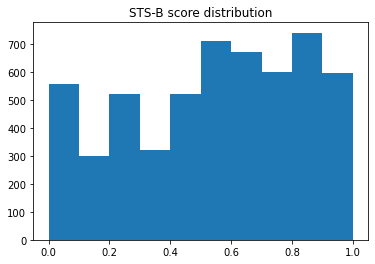

In [32]:
plt.hist(benchmark.score / 5, bins=10)
plt.title("STS-B score distribution")
plt.show()

## Compute Embeddings

In [14]:
model = SentenceTransformer("all-mpnet-base-v2")

In [16]:
s1_embeds = model.encode(benchmark.s1, convert_to_tensor=True, device=device)
s2_embeds = model.encode(benchmark.s2, convert_to_tensor=True, device=device)
# normalize embeddings, reshape for later cosine similarity
s1_embeds = F.normalize(s1_embeds)
s2_embeds = F.normalize(s2_embeds)
# print shapes
print(s1_embeds.shape, s2_embeds.shape)

torch.Size([5552, 768]) torch.Size([5552, 768])


In [40]:
sbert_scores = (s1_embeds.unsqueeze(1) @ s2_embeds.unsqueeze(2)).squeeze().cpu().numpy()

scaler = MinMaxScaler()
sbert_scores = scaler.fit_transform(sbert_scores.reshape(-1, 1)).squeeze()

sbert_scores.shape

(5552,)

In [41]:
print("Spearmans rank:", spearmanr(benchmark.score, sbert_scores))

Spearmans rank: SpearmanrResult(correlation=0.842105073697038, pvalue=0.0)


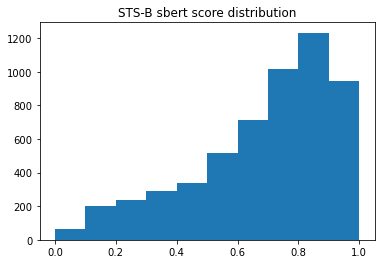

In [42]:
plt.hist(sbert_scores, bins=10)
plt.title("STS-B sbert score distribution")
plt.show()

In [43]:
df_sbert = pd.DataFrame({
    "idx1": list(range(len(benchmark.s1))),
    "idx2": list(range(len(benchmark.s2))),
    "score": sbert_scores,
})
df_sbert

,idx1,idx2,score
0,0,0,0.964444
1,1,1,0.884623
2,2,2,0.887131
3,3,3,0.826496
4,4,4,0.913931
...,...,...,...
5547,5547,5547,0.528989
5548,5548,5548,0.927525
5549,5549,5549,0.914124
5550,5550,5550,0.115019


In [44]:
df_sbert.to_feather(data_dir / "df_sbert.feather")

## Create new sentence pairs and score them via cosine similarity

In [17]:
# get the index of the unique sentences
s1_unique_idxs = benchmark.s1.drop_duplicates().index.values
s2_unique_idxs = benchmark.s2.drop_duplicates().index.values
# create array that holds all possible index combinations
index_pairs = np.stack(np.meshgrid(s1_unique_idxs, s2_unique_idxs), axis=-1).reshape(-1, 2)
index_pairs.shape

(27441810, 2)

In [8]:
dataloader = torch.utils.data.DataLoader(index_pairs, batch_size=8192)
scores = torch.cat([
    s1_embeds[idxs[:, 0]] @ s2_embeds[idxs[:, 1]]
    for idxs in tqdm(dataloader)
]).squeeze().cpu()

  0%|          | 0/3350 [00:00<?, ?it/s]

In [9]:
df_augment = pd.DataFrame({
    "idx1": index_pairs[..., 0],
    "idx2": index_pairs[..., 1],
    "score": scores.numpy()
})
df_augment

,idx1,idx2,score
0,0,0,0.939303
1,1,0,0.067502
2,2,0,0.063003
3,3,0,-0.007448
4,4,0,0.039570
...,...,...,...
27441805,5547,5551,0.220151
27441806,5548,5551,0.609874
27441807,5549,5551,0.157189
27441808,5550,5551,0.143906


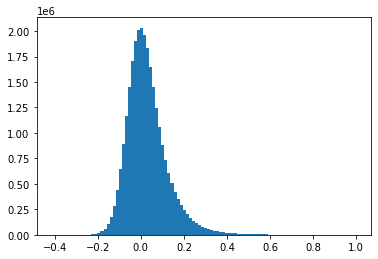

In [10]:
plt.hist(df_augment.score, bins=100)
plt.show()

In [11]:
# select evenly distributed
bins = np.histogram_bin_edges(df_augment.score, bins=1000)
indices = np.digitize(df_augment.score, bins)
indices.shape

(27441810,)

In [12]:
N_SAMPLE = 1_000
sample_idxs = []

for i in tqdm(range(1000)):
    bin_indices = np.where(indices == i)[0]
    if len(bin_indices) > 1:
        sample_idxs.append(np.random.choice(bin_indices, size=N_SAMPLE))

sample_idxs = np.concatenate(sample_idxs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
df_augment = df_augment.iloc[sample_idxs].reset_index()
df_augment

,index,idx1,idx2,score
0,7660665,45,1662,-0.362852
1,7660627,7,1662,-0.363335
2,7660665,45,1662,-0.362852
3,7660665,45,1662,-0.362852
4,7660665,45,1662,-0.362852
...,...,...,...,...
951995,23909910,4851,4851,0.998533
951996,2828583,493,617,0.997185
951997,2828583,493,617,0.997185
951998,2828583,493,617,0.997185


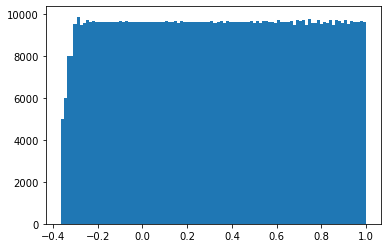

In [14]:
plt.hist(df_augment.score, bins=100)
plt.show()

In [15]:
df_augment.to_feather(data_dir / "df_augment.feather")